# 유전 알고리즘

이 노트북은 [AI for Beginners Curriculum](http://github.com/microsoft/ai-for-beginners)의 일부입니다.


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## 이론

**유전 알고리즘**(Genetic Algorithms, GA)은 **진화적 접근법**을 기반으로 한 AI 방법으로, 개체군의 진화 방식을 활용하여 주어진 문제에 대한 최적의 해를 찾는 데 사용됩니다. 유전 알고리즘은 [John Henry Holland](https://en.wikipedia.org/wiki/John_Henry_Holland)에 의해 1975년에 제안되었습니다.

유전 알고리즘은 다음과 같은 아이디어를 기반으로 합니다:
* 문제의 유효한 해는 **유전자**로 표현될 수 있습니다.
* **교차**는 두 개의 해를 결합하여 새로운 유효한 해를 얻을 수 있게 합니다.
* **선택**은 특정 **적합도 함수**를 사용하여 더 최적의 해를 선택하는 데 사용됩니다.
* **돌연변이**는 최적화를 불안정하게 만들어 지역 최소값에서 벗어날 수 있도록 도입됩니다.

유전 알고리즘을 구현하려면 다음이 필요합니다:

 * **유전자** $g\in\Gamma$를 사용하여 문제의 해를 코딩하는 방법을 찾아야 합니다.
 * 유전자 집합 $\Gamma$에서 **적합도 함수** $\mathrm{fit}: \Gamma\to\mathbb{R}$를 정의해야 합니다. 함수 값이 작을수록 더 나은 해를 나타냅니다.
 * 두 유전자를 결합하여 새로운 유효한 해를 얻는 **교차** 메커니즘 $\mathrm{crossover}: \Gamma^2\to\Gamma$를 정의해야 합니다.
 * **돌연변이** 메커니즘 $\mathrm{mutate}: \Gamma\to\Gamma$를 정의해야 합니다.
많은 경우, 교차와 돌연변이는 유전자를 숫자 시퀀스나 비트 벡터로 조작하는 간단한 알고리즘으로 구현됩니다.

유전 알고리즘의 구체적인 구현은 사례마다 다를 수 있지만, 전체적인 구조는 다음과 같습니다:

1. 초기 개체군 $G\subset\Gamma$을 선택합니다.
2. 이 단계에서 수행할 작업(교차 또는 돌연변이)을 무작위로 선택합니다.
3. **교차**:
  * 두 유전자 $g_1, g_2 \in G$를 무작위로 선택합니다.
  * 교차를 계산합니다: $g=\mathrm{crossover}(g_1,g_2)$
  * 만약 $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ 또는 $\mathrm{fit}(g)<\mathrm{fit}(g_2)$라면, 개체군에서 해당 유전자를 $g$로 대체합니다.
4. **돌연변이** - 무작위로 유전자 $g\in G$를 선택하고 이를 $\mathrm{mutate}(g)$로 대체합니다.
5. $\mathrm{fit}$ 값이 충분히 작아질 때까지, 또는 단계 수 제한에 도달할 때까지 2단계부터 반복합니다.

유전 알고리즘으로 주로 해결되는 작업:
1. 일정 최적화
1. 최적의 포장
1. 최적의 절단
1. 완전 탐색 속도 향상


## 문제 1: 공정한 보물 분배

**과제**:  
두 사람이 서로 다른 크기(그리고 이에 따라 다른 가격)의 다이아몬드로 이루어진 보물을 발견했습니다. 이들은 보물을 두 부분으로 나누어 가격 차이가 0(또는 최소)이 되도록 해야 합니다.

**정식 정의**:  
숫자 집합 $S$가 주어졌습니다. 이를 두 개의 부분 집합 $S_1$과 $S_2$로 나누어야 합니다. 이때 $$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$ 조건을 만족하고, $S_1\cup S_2=S$, $S_1\cap S_2=\emptyset$이어야 합니다.

먼저, 집합 $S$를 정의해 봅시다:


In [3]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[8344 2197 9335 3131 5863 9429 3818 9791   15 5455 1396 9538 4872 6549
 8587 5986 6021 9764 8102 5083 5739 7684 8498 3007 6599  820 7490 2372
 9370 5235 3525 3154  859 1906 8159 3950 2173 2988 2050  349 8713 2284
 4177 6033 1651 9176 5049 8201  171 5081 1216 3756 4711 2757 7738 1272
 5650 6584 5395 9004 7797  969 8104 1283 1392 4001 5768  445  274  256
 8239 8015 4381 9021 1189 8879 1411 3539 6526 8011  136 7230 2332  451
 5702 2989 4320 2446 9578 8486 4027 2410 9588 8981 2177 1493 3232 9151
 4835 5594 6859 8394  369 3200  126 4259 2283 7755 2014 2458 8327 8082
 7413 7622 1206 5533 8751 3495 5868 8472 6850 3958 3149 4672 4810 6274
 4700 6134 4627 4616 6656 9949  884 2256 7419 1926 7973 5319 5967 9158
 3823 7697 9466 5675 5412 9784 5426 8209 3421 1136 6047 4429 8001 4417
 1381  722 7350 6018 6235 7860 5853 7660 5937 6242    1 9552 3971 8302
 2633 9227 7283  154 8599 4269 9392 8539 1630  368 2409 9351 3838 9814
 6186 5743 5083 1325 1610  779 3643 3262 5768 8725  961 4611 6310 4788
 1648 

문제의 각 가능한 해를 이진 벡터 $B\in\{0,1\}^N$로 인코딩합시다. 여기서 $i$번째 위치의 숫자는 원래 집합 $S$에서 $i$번째 숫자가 어떤 집합($S_1$ 또는 $S_2$)에 속하는지를 나타냅니다. `generate` 함수는 이러한 랜덤 이진 벡터를 생성할 것입니다.


In [5]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0]


이제 `fit` 함수를 정의하여 해답의 "비용"을 계산해 봅시다. 이는 두 집합 $S_1$과 $S_2$의 합의 차이가 될 것입니다:


In [6]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

133784

이제 돌연변이와 교차를 위한 함수를 정의해야 합니다:
* 돌연변이의 경우, 임의의 비트를 하나 선택하여 반전시킵니다 (0을 1로, 1을 0으로 변경)
* 교차의 경우, 한 벡터에서 일부 비트를 가져오고, 다른 벡터에서 일부 비트를 가져옵니다. 어떤 입력 마스크에서 어떤 비트를 가져올지 무작위로 선택하기 위해 동일한 `generate` 함수를 사용할 것입니다.


In [7]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

해결책 $P$의 초기 개체군을 크기 `pop_size`로 생성합시다.


In [8]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

이제 진화를 수행하는 주요 함수입니다. `n`은 수행할 진화 단계의 수를 나타냅니다. 각 단계에서:

* 30%의 확률로 돌연변이를 수행하며, 가장 낮은 `fit` 함수를 가진 요소를 돌연변이된 요소로 교체합니다.
* 70%의 확률로 교차를 수행합니다.

이 함수는 최적의 해 (최적의 해에 해당하는 유전자)와 각 반복에서 집단 내 최소 `fit` 함수의 기록을 반환합니다.


In [9]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0
 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1] 4


우리가 `fit` 함수를 상당히 최소화한 것을 볼 수 있습니다! 다음은 전체 집단에 대한 `fit` 함수가 과정 중 어떻게 작동하는지를 보여주는 그래프입니다.


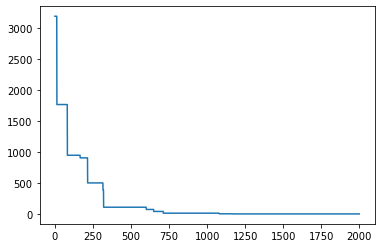

In [10]:
plt.plot(hist)
plt.show()

## 문제 2: N-퀸 문제

**과제**:  
$N \times N$ 크기의 체스판에 $N$개의 퀸을 서로 공격하지 않도록 배치해야 합니다.

우선, 유전 알고리즘을 사용하지 않고 완전 탐색을 통해 문제를 해결해 봅시다. 체스판의 상태는 리스트 $L$로 표현할 수 있습니다. 여기서 리스트의 $i$번째 숫자는 $i$번째 행에서 퀸의 가로 위치를 나타냅니다. 각 해답은 한 행에 하나의 퀸만 배치되며, 모든 행에 퀸이 배치된다는 점은 자명합니다.

우리의 목표는 문제의 첫 번째 해답을 찾는 것이며, 해답을 찾은 후 탐색을 중단합니다. 이 함수를 확장하여 퀸의 모든 가능한 배치 위치를 생성할 수도 있습니다.


In [11]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False
            
nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

이제 20-퀸 문제의 해를 얻는 데 얼마나 시간이 걸리는지 측정해 봅시다:


In [12]:
%timeit nqueens([],20,False)

10.6 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


이제 유전 알고리즘을 사용하여 동일한 문제를 해결해 봅시다. 이 솔루션은 [이 블로그 게시물](https://kushalvyas.github.io/gen_8Q.html)에서 영감을 받았습니다.

각 솔루션은 길이가 $N$인 동일한 리스트로 표현되며, `fit` 함수로는 서로 공격하는 퀸의 수를 계산합니다:


In [13]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

피트니스 함수를 계산하는 데 시간이 많이 소요되므로, 각 솔루션을 피트니스 함수 값과 함께 개체군에 저장합시다. 초기 개체군을 생성해 봅시다:


In [14]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([2, 3, 8, 7, 5, 4, 1, 6]), 4),
 (array([3, 4, 5, 1, 2, 8, 6, 7]), 8),
 (array([1, 3, 7, 4, 5, 8, 6, 2]), 6),
 (array([1, 5, 4, 6, 8, 3, 7, 2]), 4),
 (array([3, 5, 7, 1, 8, 6, 4, 2]), 3)]

이제 돌연변이와 교차 함수들을 정의해야 합니다. 교차는 두 유전자를 임의의 지점에서 나누고 서로 다른 유전자에서 나온 두 부분을 결합하여 하나로 만드는 것입니다.


In [15]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G
    
def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1, 2, 7, 8])

In [17]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

이제 주요 진화 루프를 정의해 보겠습니다. 이전 예제와는 약간 다른 논리를 사용하여 창의적으로 접근할 수 있음을 보여드리겠습니다. 우리는 완벽한 해답(적합도 함수=0)을 얻을 때까지 반복하며, 각 단계에서 현재 세대를 가져와 동일한 크기의 새로운 세대를 생성합니다. 이는 `nxgeneration` 함수를 사용하여 다음 단계로 수행됩니다:

1. 가장 적합하지 않은 해답을 제거합니다 - 이를 수행하는 `discard_unfit` 함수가 있습니다.
1. 세대에 몇 가지 더 랜덤한 해답을 추가합니다.
1. 각 새로운 유전자에 대해 다음 단계를 사용하여 크기가 `gen_size`인 새로운 세대를 채웁니다:
    - 적합도 함수에 비례하는 확률로 두 개의 랜덤 유전자를 선택합니다.
    - 교차(crossover)를 계산합니다.
    - `mutation_prob` 확률로 돌연변이를 적용합니다.


In [20]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen
    
def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([4, 7, 5, 3, 1, 6, 8, 2]), 0)

In [19]:
%timeit genetic(10)

The slowest run took 18.71 times longer than the fastest. This could mean that an intermediate result is being cached.
26.4 s ± 28.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



---

**면책 조항**:  
이 문서는 AI 번역 서비스 [Co-op Translator](https://github.com/Azure/co-op-translator)를 사용하여 번역되었습니다. 정확성을 위해 최선을 다하고 있지만, 자동 번역에는 오류나 부정확성이 포함될 수 있습니다. 원본 문서의 원어 버전을 권위 있는 출처로 간주해야 합니다. 중요한 정보의 경우, 전문적인 인간 번역을 권장합니다. 이 번역 사용으로 인해 발생하는 오해나 잘못된 해석에 대해 책임을 지지 않습니다.
